# Contents:
- [1. Import Libraries & Data](#import-libraries)
- [2. Data Preprocessing](#data-preprocessing)
- [3. Models Experiments](#models)
    - [3.1 All Features](#All-Features)
    - [3.2 Feature-Selection](#Feature-Selection)
    - [3.3 Feature Selection using PCA](#Feature-Selection-PCA)
- [4. ANN](#ann)

<a id="import-libraries"></a>
# 1. Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('../../data/processed/trial4.csv')

In [3]:
data.head(2)

,logkpl,Texpi,ALogP,ALogp2,AMR,apol,nAcid,naAromAtom,nAromBond,nAtom,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,-2.25,298,1.4570,2.122849,35.0768,17.399965,0,6,6,15,...,139.109037,19.385708,1.938571,10.344796,7.326862,3.017933,120.0,11.0,1.508,46.0
1,-2.95,310,3.6304,13.179804,49.4776,32.539860,1,0,0,32,...,172.264984,22.661828,1.888486,4.763098,4.763098,0.000000,277.0,9.0,4.156,44.0


In [4]:
data.shape

(450, 224)

In [5]:
# no missing values
data.isna().sum().sum()

0

<a id="data-preprocessing"></a>
# 2. Data Preprocessing

In [6]:
model_data = data.copy()

In [7]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (337, 223) 	 Shape of y_train: (337,)
Shape of X_test: (113, 223) 	 Shape of y_test: (113,)


<a id="models"></a>
# 3. Models Experiments

In [8]:
def plot_feature_importance(model, cols, model_name, slice=20):
    importances = model.feature_importances_
    feature_names = cols#X.columns#selected_features_X.columns #

    # Create a pandas DataFrame with the feature importances
    df = pd.DataFrame({"feature": feature_names, "importance": importances})

    # Sort the DataFrame by importance score
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)

    # Create a bar plot using Seaborn
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(x="importance", y="feature", data=df[:slice])
    plt.title("Top 20 Feature Importances {}".format(model_name))
    plt.ylabel("Feature Name")
    plt.xlabel("Importance")
    plt.show()

<a id="All-Features"></a>
### 3.1 All Features

In [9]:
def evaluate_model(model_df, i, model_name, model, X, y, X_test, y_test):
    """
    this function is for regression takes the model with the data and calculate
    the scores, with cross validation techniques, in addition to MAE, MSE, RMSE, MAPE
    R Squared and Adjusted R Squared

    :param model: model
    :param X_train, X_test, y_train, y_test: data that was used
    """

    # cross validation with 5 folds
    all_cv_5 = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_percentage_error")
    #print("all CV 5: {}".format(all_cv_5))
    # print("Mean Cross-Validation score: {}".format(all_cv_5.mean()))

    # predictions from our model
    predictions = model.predict(X_test)


    # calculating R squared and Adjusted R squared
    r_sqre = r2_score(y_test, predictions)
    n = len(y_test)
    p = X_test.shape[1] # number of independant features

    Adj_r2 = 1 - ((1 - r_sqre) * (n - 1) / (n - 1 - p))
    
    test_mae = mean_absolute_error(y_test, predictions)

    test_mse = mean_squared_error(y_test, predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    


    #print("=" * 40)
    model_df.loc[i] = [model_name, all_cv_5.mean(),
                    test_mae, mean_absolute_percentage_error(y_test, predictions),
                   test_mse, test_rmse, r_sqre, Adj_r2]

    return model_df

In [10]:
def train_and_evalute(X, y, metric):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

    print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
    print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

    # Building pipelins of standard scaler and model for varios regressors.

    lr = LinearRegression()

    lasso = Lasso()

    dt = DecisionTreeRegressor()

    rf = RandomForestRegressor()

    xgb = XGBRegressor()

    gbr = GradientBoostingRegressor()

    eln = ElasticNet()

    br = BayesianRidge()

    cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

    lgbm = LGBMRegressor()



    # List of all the pipelines
    pipelines = [lr, lasso, dt, rf, xgb, gbr,
                eln, br, cat, lgbm] # 

    # Dictionary of pipelines and model types for ease of reference
    ml_dict = {0: "LinearRegression", 1: "Lasso", 2: "DecisionTree", 3: "RandomForest", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                    6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
        #, 

    models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                            "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



    # Fit the pipelines and display the scores with Cross validation
    for i, pipe in enumerate(pipelines):
        # getting the name of our model
        model_name = ml_dict[i]
        print(model_name)
        
        # fitting our data
        pipe.fit(X_train, y_train)
        
        evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)


    # selecting top 3 score based on metric
    filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

    for i in filtered_models_scores_df.index:
        plot_feature_importance(pipelines[i],  X.columns, ml_dict[i])

    return models_scores_df

Shape of X_train: (337, 223) 	 Shape of y_train: (337,)
Shape of X_test: (113, 223) 	 Shape of y_test: (113,)
LinearRegression
Lasso


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+00, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e-01, tolerance: 3.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

DecisionTree
RandomForest
XGBRegressor
GradientBoostingRegressor
Elastic Net
BayesianRidge


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.873e+00, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.355e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

CatBoostRegressor
LGBMRegressor


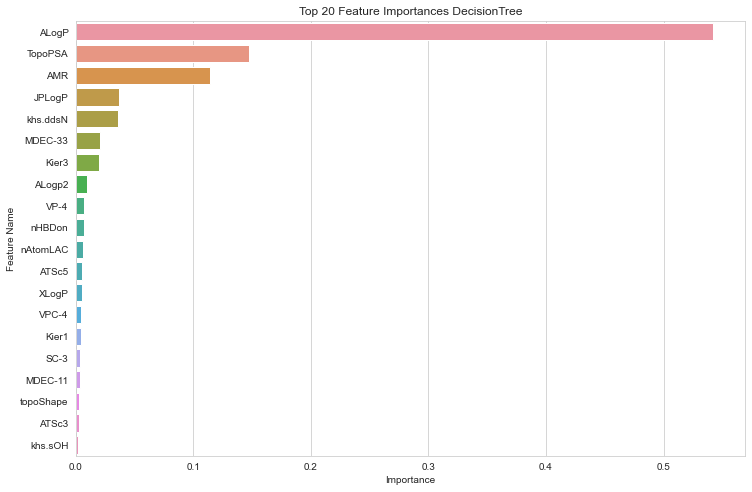

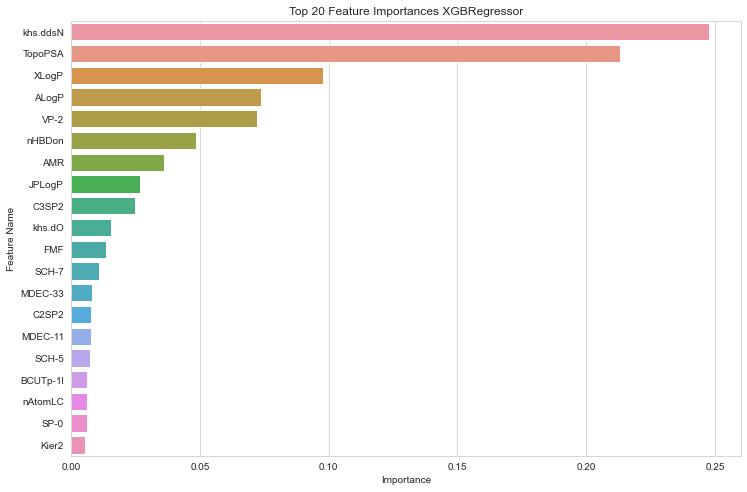

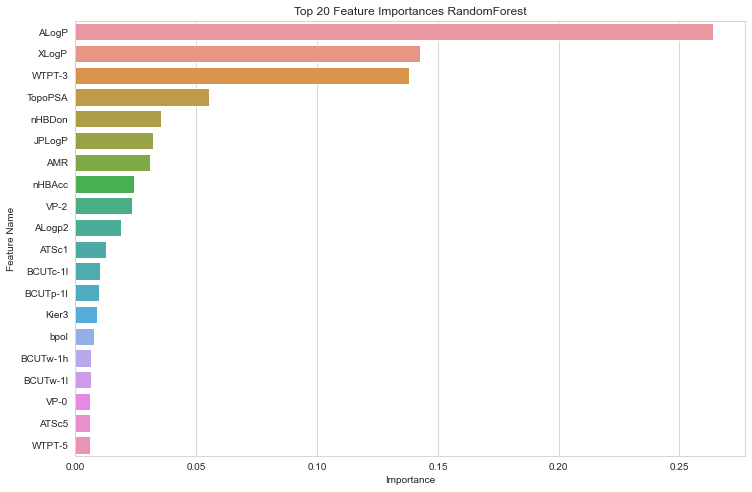

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,LinearRegression,-2.723782e+08,3.080510e+10,1.309154e+10,2.007174e+22,1.416748e+11,-1.482863e+22,1.496222e+22
1,Lasso,-4.091867e-01,9.734274e-01,7.433510e-01,1.354955e+00,1.164025e+00,-1.015262e-03,2.010033e+00
2,DecisionTree,-2.947590e-01,5.146232e-01,3.384617e-01,5.087949e-01,7.132986e-01,6.241117e-01,1.379275e+00
3,RandomForest,-2.443297e-01,4.668781e-01,3.901657e-01,4.203261e-01,6.483256e-01,6.894709e-01,1.313327e+00
4,XGBRegressor,-2.483595e-01,4.979689e-01,3.626972e-01,4.753140e-01,6.894302e-01,6.488469e-01,1.354317e+00
5,GradientBoostingRegressor,-2.351166e-01,4.758395e-01,4.092906e-01,4.444153e-01,6.666448e-01,6.716742e-01,1.331284e+00
6,Elastic Net,-3.945067e-01,9.047934e-01,7.004029e-01,1.163201e+00,1.078518e+00,1.406485e-01,1.867093e+00
7,BayesianRidge,-3.161020e-01,5.044380e-01,4.072736e-01,5.351598e-01,7.315462e-01,6.046339e-01,1.398928e+00
8,CatBoostRegressor,-2.474699e-01,4.757227e-01,4.000842e-01,4.397612e-01,6.631450e-01,6.751126e-01,1.327814e+00
9,LGBMRegressor,-2.546325e-01,4.782828e-01,4.060710e-01,4.656290e-01,6.823702e-01,6.560019e-01,1.347097e+00


In [11]:
all_features = train_and_evalute(X, y, metric="MAPE")
all_features

<a id="Feature-Selection"></a>
### 3.2 Feature Selection

In [12]:
import statsmodels.api as sm
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(GradientBoostingRegressor(), 
           k_features=15,
           forward=True, 
           floating=False, 
           verbose=0,
           scoring="neg_mean_absolute_percentage_error",
           cv=0)

sfs1 = sfs1.fit(X, y)

In [14]:
# try selecting more features
sfs1.k_feature_names_

('nAtom',
 'ATSc3',
 'ATSc4',
 'ATSm5',
 'ATSp5',
 'BCUTp-1l',
 'SCH-7',
 'VC-6',
 'VP-4',
 'VP-6',
 'FMF',
 'JPLogP',
 'MDEC-12',
 'TopoPSA',
 'XLogP')

In [15]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(78,)",[-0.20010936681143557],-0.200109,"(VP-4,)",NaN,0.0,NaN
2,"(78, 210)",[-0.15591571330861745],-0.155916,"(VP-4, TopoPSA)",NaN,0.0,NaN
3,"(12, 78, 210)",[-0.1459545645465073],-0.145955,"(ATSc4, VP-4, TopoPSA)",NaN,0.0,NaN
4,"(12, 78, 210, 221)",[-0.14275823637857804],-0.142758,"(ATSc4, VP-4, TopoPSA, XLogP)",NaN,0.0,NaN
5,"(12, 78, 80, 210, 221)",[-0.13841826267534424],-0.138418,"(ATSc4, VP-4, VP-6, TopoPSA, XLogP)",NaN,0.0,NaN
6,"(11, 12, 78, 80, 210, 221)",[-0.13764980640131905],-0.13765,"(ATSc3, ATSc4, VP-4, VP-6, TopoPSA, XLogP)",NaN,0.0,NaN
7,"(11, 12, 28, 78, 80, 210, 221)",[-0.13497015931569553],-0.13497,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, TopoPSA, ...",NaN,0.0,NaN
8,"(11, 12, 28, 78, 80, 89, 210, 221)",[-0.13128494025202264],-0.131285,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, JPLogP, T...",NaN,0.0,NaN
9,"(11, 12, 28, 78, 80, 89, 176, 210, 221)",[-0.1301085265214019],-0.130109,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, JPLogP, M...",NaN,0.0,NaN
10,"(11, 12, 28, 78, 80, 83, 89, 176, 210, 221)",[-0.12939687333513109],-0.129397,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, FMF, JPLo...",NaN,0.0,NaN


Shape of X_train: (337, 15) 	 Shape of y_train: (337,)
Shape of X_test: (113, 15) 	 Shape of y_test: (113,)
LinearRegression
Lasso
DecisionTree
RandomForest
XGBRegressor
GradientBoostingRegressor
Elastic Net
BayesianRidge
CatBoostRegressor
LGBMRegressor


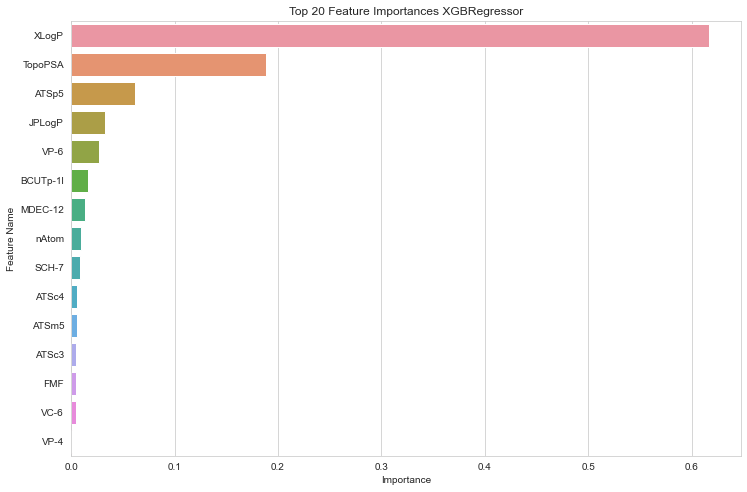

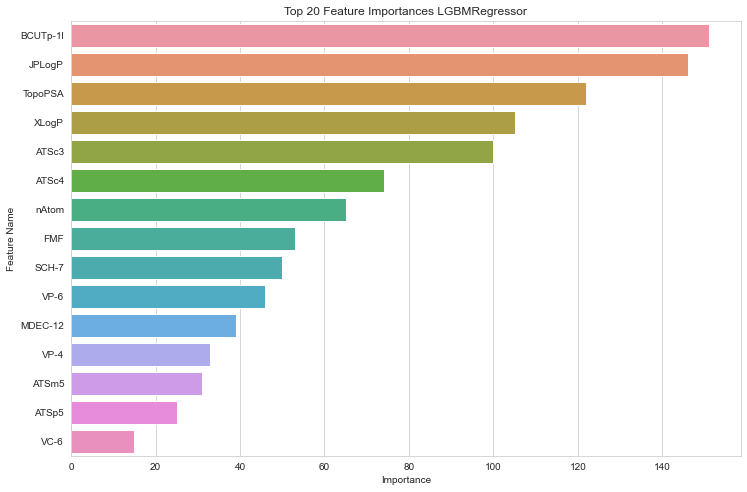

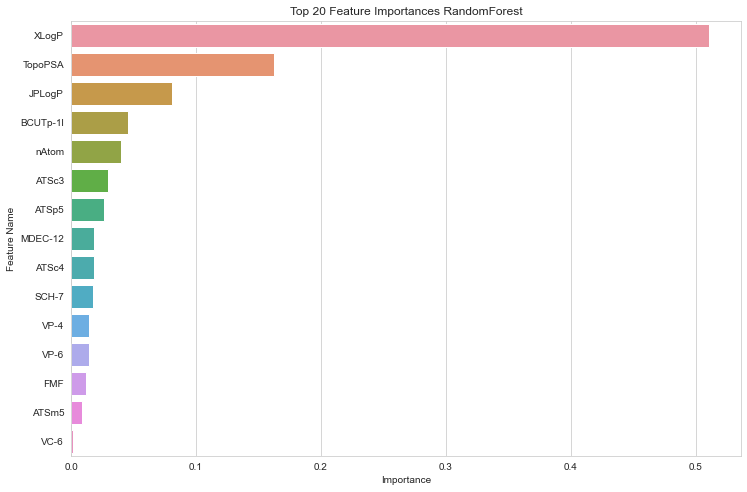

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,LinearRegression,-0.415662,0.699380,0.532875,0.857600,0.926067,0.366421,0.268445
1,Lasso,-0.423370,0.973427,0.743351,1.354955,1.164025,-0.001015,-0.155811
2,DecisionTree,-0.302107,0.530928,0.389821,0.566712,0.752803,0.581324,0.516580
3,RandomForest,-0.257463,0.460777,0.368172,0.421407,0.649158,0.688673,0.640529
4,XGBRegressor,-0.262768,0.473859,0.357891,0.452601,0.672756,0.665627,0.613920
5,GradientBoostingRegressor,-0.250169,0.468296,0.389406,0.467399,0.683666,0.654695,0.601297
6,Elastic Net,-0.415209,0.918350,0.710563,1.198713,1.094858,0.114413,-0.022533
7,BayesianRidge,-0.407000,0.697958,0.534132,0.832778,0.912567,0.384759,0.289618
8,CatBoostRegressor,-0.253290,0.484504,0.402669,0.452396,0.672604,0.665778,0.614095
9,LGBMRegressor,-0.254476,0.446234,0.364477,0.405658,0.636913,0.700307,0.653963


In [16]:
selected_features_X = X.iloc[:, list(sfs1.k_feature_idx_)]
y = model_data['logkpl']

train_and_evalute(selected_features_X, y, metric="MAPE")

In [17]:
calc_vif(selected_features_X)

,variables,VIF
0,nAtom,131.890992
1,ATSc3,6.296528
2,ATSc4,4.628750
3,ATSm5,132.665400
4,ATSp5,200.105858
5,BCUTp-1l,33.861533
6,SCH-7,49.246722
7,VC-6,18.231877
8,VP-4,1187.995026
9,VP-6,846.353572


<a id="Feature-Selection-PCA"></a>
### 3.3 Feature Selection using PCA

In [28]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA


# initilizing and fitting the pca
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print("Number of Components by PCA", X_pca.shape[1])
print("Explained Variance Ratio", pca.explained_variance_ratio_.sum())

Number of Components by PCA 36
Explained Variance Ratio 0.9910016806575245


In [29]:
pca.components_.shape[0]

36

In [39]:
test_ = pd.DataFrame(pca.components_.T, index = {'PC{}'.format(i+1) for i in range(X_pca.shape[1])}) #columns=X.columns,


ValueError: Shape of passed values is (223, 36), indices imply (36, 36)

In [ ]:
test_

,Texpi,ALogP,ALogp2,AMR,apol,nAcid,naAromAtom,nAromBond,nAtom,ATSc1,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
PC22,-0.031134,0.030326,0.029669,0.114115,0.115273,-0.010320,-0.029310,-0.028832,0.114519,0.052669,...,0.101812,0.115455,0.064667,0.032302,0.060440,-0.018330,0.103617,0.117898,0.023811,0.117122
PC26,0.010533,0.008850,0.010250,-0.002350,-0.004319,-0.001354,0.021178,0.022900,-0.004386,-0.006872,...,0.069261,-0.012309,0.096491,0.133848,-0.005664,0.005569,-0.007815,-0.007042,-0.006046,-0.007859
PC18,0.051618,-0.196747,0.021007,-0.016240,-0.003918,0.019890,-0.137567,-0.136193,0.017040,0.199363,...,0.022298,0.006382,-0.075486,0.122665,0.199015,0.005294,0.056777,0.005852,-0.188817,-0.003149
PC5,0.100162,-0.031766,0.043603,0.046351,0.021389,0.057670,0.202798,0.203425,0.009061,0.114939,...,0.072590,0.061656,0.090736,0.128473,0.064389,0.185328,0.068606,0.021310,-0.029105,0.044390
PC19,0.013156,0.169669,0.171723,0.068874,0.071087,0.008856,0.064905,0.063447,0.075688,-0.055343,...,0.063525,0.028867,0.056302,-0.024750,-0.046111,-0.050427,0.030127,-0.031660,0.162314,-0.012495
PC3,-0.038630,0.022768,-0.123096,0.029593,0.026201,0.075240,-0.064603,-0.062018,0.029834,0.011610,...,-0.035915,0.010416,-0.123941,0.006293,-0.069951,0.210349,0.058728,0.006815,0.005178,0.014053
PC20,0.074036,0.065755,0.129346,0.029632,0.037801,-0.014044,0.073475,0.070509,0.040948,-0.033702,...,-0.069635,0.018906,-0.120407,-0.075146,0.036866,-0.091467,0.038523,0.024288,0.084629,0.035862
PC11,-0.027987,-0.031357,-0.119799,-0.006994,-0.010037,-0.038942,-0.035307,-0.038564,-0.012992,-0.002797,...,-0.015015,-0.010449,-0.052940,-0.000013,-0.021083,0.030460,-0.003296,-0.000883,-0.045563,-0.002798
PC12,0.075948,0.004944,0.053060,-0.003113,0.005771,0.138356,0.012995,0.019829,0.015674,-0.013816,...,-0.019384,0.013657,0.028088,-0.035190,-0.022426,0.063407,0.027432,0.010967,-0.028877,0.007813
PC13,-0.106433,0.033448,-0.016095,0.010013,-0.000685,0.189053,-0.025590,-0.023749,-0.008754,-0.007759,...,0.012833,0.015194,-0.008154,-0.005839,-0.007580,-0.028162,0.083090,-0.001552,0.021814,0.005351


In [30]:
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


X_pca_df = pd.DataFrame(X_pca, columns=most_important_names)

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df[1].duplicated().sum()

8

In [31]:
X.columns.shape

(223,)

In [32]:
most_important

[20,
 205,
 185,
 200,
 92,
 218,
 168,
 203,
 25,
 124,
 33,
 116,
 162,
 143,
 138,
 145,
 146,
 0,
 141,
 129,
 123,
 129,
 100,
 113,
 100,
 5,
 100,
 162,
 13,
 103,
 103,
 145,
 0,
 110,
 13,
 190]

In [ ]:
pca_features = train_and_evalute(X_pca_df, y, metric="MAPE")
pca_features

Shape of X_train: (337, 36) 	 Shape of y_train: (337,)
Shape of X_test: (113, 36) 	 Shape of y_test: (113,)
LinearRegression
Lasso
DecisionTree
RandomForest
XGBRegressor


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 931, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 401, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 945, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 666, in __init__
    self.feature_names = feature_names
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 1035, in feature_names
    raise ValueError('feature_names must be unique')
ValueError: feature_names must be unique


<a id="ann"></a>
# 4. ANN

In [ ]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([

tf.keras.layers.Dense(256, input_shape=[X.shape[1]]),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(128),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(64),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(32),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(8),
tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss="mean_absolute_error")

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               57344     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)               

In [ ]:
history = model.fit(X_train, y_train, epochs=2500, validation_data=(X_test, y_test), verbose=2)

Epoch 1/2500
11/11 - 0s - loss: 3.9091 - val_loss: 2.9746 - 360ms/epoch - 33ms/step
Epoch 2/2500
11/11 - 0s - loss: 3.4759 - val_loss: 2.6915 - 29ms/epoch - 3ms/step
Epoch 3/2500
11/11 - 0s - loss: 3.3654 - val_loss: 2.6072 - 30ms/epoch - 3ms/step
Epoch 4/2500
11/11 - 0s - loss: 3.0269 - val_loss: 2.5554 - 32ms/epoch - 3ms/step
Epoch 5/2500
11/11 - 0s - loss: 2.8466 - val_loss: 2.4987 - 32ms/epoch - 3ms/step
Epoch 6/2500
11/11 - 0s - loss: 2.8627 - val_loss: 2.4583 - 33ms/epoch - 3ms/step
Epoch 7/2500
11/11 - 0s - loss: 2.7404 - val_loss: 2.3424 - 30ms/epoch - 3ms/step
Epoch 8/2500
11/11 - 0s - loss: 2.3637 - val_loss: 2.2188 - 31ms/epoch - 3ms/step
Epoch 9/2500
11/11 - 0s - loss: 2.5620 - val_loss: 2.2084 - 31ms/epoch - 3ms/step
Epoch 10/2500
11/11 - 0s - loss: 2.5035 - val_loss: 2.0589 - 30ms/epoch - 3ms/step
Epoch 11/2500
11/11 - 0s - loss: 2.5770 - val_loss: 1.9591 - 31ms/epoch - 3ms/step
Epoch 12/2500
11/11 - 0s - loss: 2.3962 - val_loss: 1.9314 - 30ms/epoch - 3ms/step
Epoch 13/25

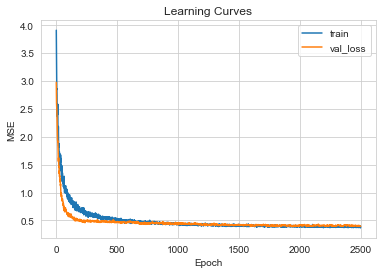

In [ ]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)

# MAE, MSE, RMSE
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
print("MSE: {}".format(mean_squared_error(y_test, predictions)))
print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))
print("MAPE: {}".format(mean_absolute_percentage_error(y_test, predictions)))
print("R2: {}".format(r2_score(y_test, predictions)))

4/4 [==============================] - 0s 5ms/step
MAE: 0.3959464055458001
MSE: 0.36476997993659477
RMSE: 0.6039619027195298
MAPE: 0.1634207410162327
R2: 0.7172075289252993
